## The Goal: to improuve performance of spherical_normal_saxs() function from saxskit
(to reduce the execution time keeping reasonable accuracy)

In [1]:
import numpy as np
import pandas as pd
from time import time

In [2]:
# Original function
def spherical_normal_saxs(q,r0,sigma):
    """Compute SAXS intensity of a normally-distributed sphere population.

    The returned intensity is normalized 
    such that I(q=0) is equal to 1.
    The current version samples the distribution 
    from r0*(1-5*sigma) to r0*(1+5*sigma) 
    in steps of 0.02*sigma*r0.
    Originally contributed by Amanda Fournier.
    TODO: test distribution sampling, speed up if possible.

    Parameters
    ----------
    q : array
        array of scattering vector magnitudes
    r0 : float
        mean radius of the sphere population
    sigma : float
        fractional standard deviation of the sphere population radii

    Returns
    -------
    I : array
        Array of scattering intensities for each of the input q values
    """
    q_zero = (q == 0)
    q_nz = np.invert(q_zero) 
    I = np.zeros(q.shape)
    if sigma < 1E-9:
        x = q*r0
        V_r0 = float(4)/3*np.pi*r0**3
        I[q_nz] = V_r0**2 * (3.*(np.sin(x[q_nz])-x[q_nz]*np.cos(x[q_nz]))*x[q_nz]**-3)**2
        I_zero = V_r0**2 
    else:
        sigma_r = sigma*r0
        dr = sigma_r*0.02
        rmin = np.max([r0-5*sigma_r,dr])
        rmax = r0+5*sigma_r
        I_zero = 0
        for ri in np.arange(rmin,rmax,dr):
            xi = q*ri
            V_ri = float(4)/3*np.pi*ri**3
            # The normal-distributed density of particles with radius r_i:
            rhoi = 1./(np.sqrt(2*np.pi)*sigma_r)*np.exp(-1*(r0-ri)**2/(2*sigma_r**2))
            I_zero += V_ri**2 * rhoi*dr
            I[q_nz] += V_ri**2 * rhoi*dr*(3.*(np.sin(xi[q_nz])-xi[q_nz]*np.cos(xi[q_nz]))*xi[q_nz]**-3)**2
    if any(q_zero):
        I[q_zero] = I_zero
    I = I/I_zero 
    return I

Original spherical_normal_saxs() uses **5 sigma * r0** as range and **dr = 0.2 sigma * r0** as step. It is very possible that we will have about the same accuracy using the a smaller range and bigger steps. **My goal is to find the values for these constants**. 

In [3]:
# q is always an array from 0 to 0.5 with step 0.001:
q = np.arange(0, 0.5, 0.001)

#### We need to find resonable values for r0 and sigma to use:

In [4]:
d = pd.read_csv('all_data.csv')
data = d[d['r0_sphere'].isnull() == False]
print(data.r0_sphere.min())
print(data.r0_sphere.max())
print(data.sigma_sphere.min())
print(data.sigma_sphere.max())

2.53187891908
34.1985487866
0.0
0.639287240247


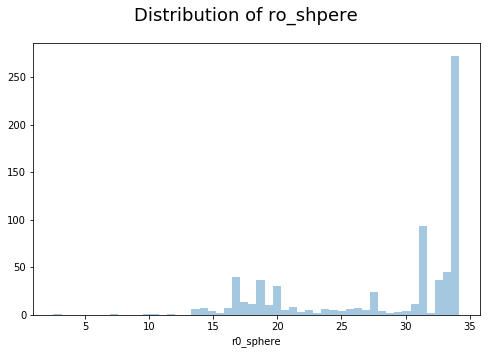

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(8,5))
sns.distplot(data['r0_sphere'], kde=False, bins=50)
plt.suptitle("Distribution of ro_shpere ", fontsize=18)

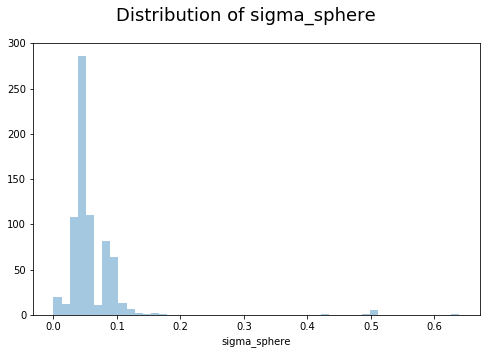

In [6]:
plt.figure(figsize=(8,5))
sns.distplot(data['sigma_sphere'], kde=False, bins=50)
plt.suptitle("Distribution of sigma_sphere ", fontsize=18)

In [48]:
# r0 has 10 values and sigma has 10 value. It gives us 100 combinations. 
r0 = [1,5,20,25,30,35,40,45,50,55]
sigma = [0.01, 0.05, 0.1,0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]

In [10]:
I = []
t0 = time()
for r in r0:
    for s in sigma:
        I.append(spherical_normal_saxs(q,r,s))
print("Executing of original function 100 times took about", (time()-t0), " seconds.")

Executing of original function 100 times took about 3.1360409259796143  seconds.


**Executinon of original spherical_normal_saxs() takes about 3.1 sec.**

I replaced 5 and 0.2 in 5 sigma * r0  and dr = 0.2 sigma * r0 by const1, const2. 

Now we can run it for different values of const1 and const2.

In [11]:
def spherical_normal_saxs_new(q,r0,sigma, const1, const2): # 5 and 0.02
    q_zero = (q == 0)
    q_nz = np.invert(q_zero) 
    I = np.zeros(q.shape)
    if sigma < 1E-9:
        x = q*r0
        V_r0 = float(4)/3*np.pi*r0**3
        I[q_nz] = V_r0**2 * (3.*(np.sin(x[q_nz])-x[q_nz]*np.cos(x[q_nz]))*x[q_nz]**-3)**2
        I_zero = V_r0**2 
    else:
        sigma_r = sigma*r0
        dr = sigma_r*const2 # was 0.2
        rmin = np.max([r0-const1*sigma_r,dr]) # was 5
        rmax = r0+const1*sigma_r # was 5
        I_zero = 0
        for ri in np.arange(rmin,rmax,dr):
            xi = q*ri
            V_ri = float(4)/3*np.pi*ri**3
            # The normal-distributed density of particles with radius r_i:
            rhoi = 1./(np.sqrt(2*np.pi)*sigma_r)*np.exp(-1*(r0-ri)**2/(2*sigma_r**2))
            I_zero += V_ri**2 * rhoi*dr
            I[q_nz] += V_ri**2 * rhoi*dr*(3.*(np.sin(xi[q_nz])-xi[q_nz]*np.cos(xi[q_nz]))*xi[q_nz]**-3)**2
    if any(q_zero):
        I[q_zero] = I_zero
    I = I/I_zero 
    return I

In [30]:
# test of our new function: should be about 3 sec
I = []
t0 = time()
for r in r0:
    for s in sigma:
        I.append(spherical_normal_saxs_new(q,r,s, 5, 0.02))
print("Executing of original function 100 times took about", (time()-t0), " seconds.")

Executing of original function 100 times took about 3.196352005004883  seconds.


In [15]:
const1 = np.arange(1, 5.5, 0.5)
const2 = np.arange(0.02, 0.3, 0.02)
print(const1)
print(const2)

[ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5. ]
[ 0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18  0.2   0.22  0.24
  0.26  0.28]


In [24]:
stat = []
for c1 in const1:
    for c2 in const2:
        I_new = []
        t0 = time()
        for r in r0:
            for s in sigma:
                I_new.append(spherical_normal_saxs_new(q,r,s, c1, c2))
        t = time()-t0
        #compare the result with the result that we got using original function:
        max_diff = []
        abs_error = []
        max_abs_log_error = []
        for i in range(100):
            max_diff.append(max(np.absolute(np.log10(I[i]) - np.log10(I_new[i]))))
            abs_error.append(sum(np.absolute(I[i] - I_new[i]))/len(I[i]))
            max_abs_log_error.append(max(np.absolute(I[i] - I_new[i])))
        stat.append([c1, c2, t, np.mean(max_diff), np.mean(abs_error), np.mean(max_abs_log_error)])

In [25]:
stat = np.array(stat)

## Visualisation of the results

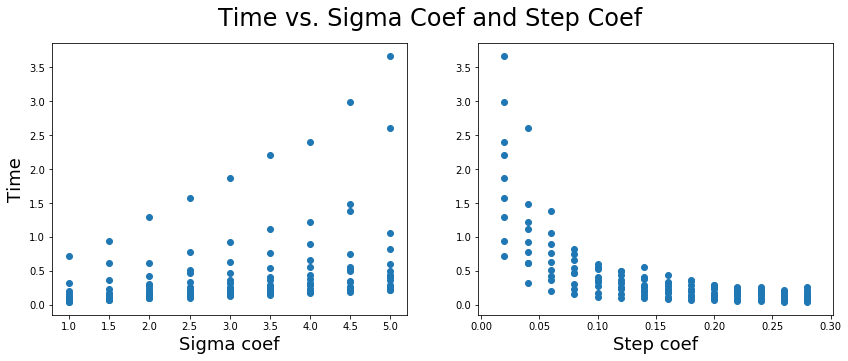

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
st = fig.suptitle("Time vs. Sigma Coef and Step Coef", fontsize=24)

axes[0].scatter(stat[ : ,0],stat[ : ,2])
axes[1].scatter(stat[ : ,1],stat[ : ,2])
axes[0].set_ylabel('Time', fontsize=18)
axes[1].yaxis.label.set_visible(False) 
axes[0].set_xlabel('Sigma coef',fontsize=18)
axes[1].set_xlabel("Step coef", fontsize=18);

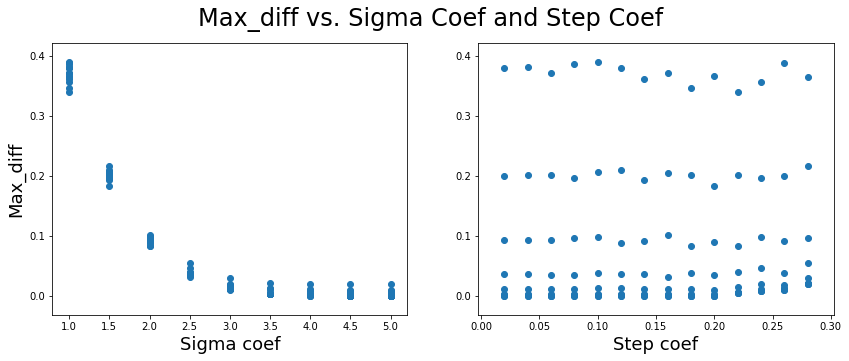

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
st = fig.suptitle("Max_diff vs. Sigma Coef and Step Coef", fontsize=24)

axes[0].scatter(stat[ : ,0],stat[ : ,3])
axes[1].scatter(stat[ : ,1],stat[ : ,3])
axes[0].set_ylabel('Max_diff', fontsize=18)
axes[1].yaxis.label.set_visible(False) 
axes[0].set_xlabel('Sigma coef',fontsize=18)
axes[1].set_xlabel("Step coef", fontsize=18);

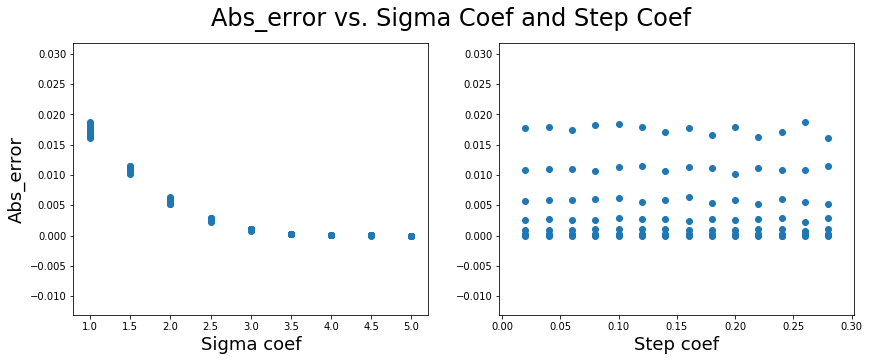

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
st = fig.suptitle("Abs_error vs. Sigma Coef and Step Coef", fontsize=24)

axes[0].scatter(stat[ : ,0],stat[ : ,4])
axes[1].scatter(stat[ : ,1],stat[ : ,4])
axes[0].set_ylabel('Abs_error', fontsize=18)
axes[1].yaxis.label.set_visible(False) 
axes[0].set_xlabel('Sigma coef',fontsize=18)
axes[1].set_xlabel("Step coef", fontsize=18);

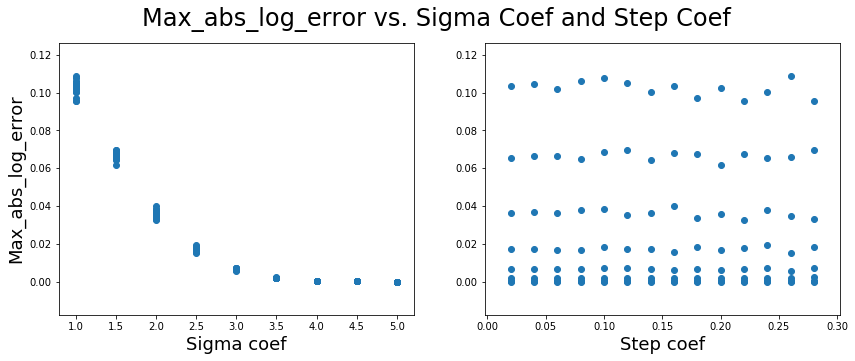

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
st = fig.suptitle("Max_abs_log_error vs. Sigma Coef and Step Coef", fontsize=24)

axes[0].scatter(stat[ : ,0],stat[ : ,5])
axes[1].scatter(stat[ : ,1],stat[ : ,5])
axes[0].set_ylabel('Max_abs_log_error', fontsize=18)
axes[1].yaxis.label.set_visible(False) 
axes[0].set_xlabel('Sigma coef',fontsize=18)
axes[1].set_xlabel("Step coef", fontsize=18);

###  coef1 = 3.5 and coef2 = 0.25

In [47]:
# test of our function with new constants: should be less than 3 sec
I_new = []# I_new calculated with new coefficients
t0 = time()
for r in r0:
    for s in sigma:
        I_new.append(spherical_normal_saxs_new(q,r,s, 3.5, 0.25))
print("Executing of original function with new coefficients 100 times took about", (time()-t0), " seconds.")

Executing of original function with new coefficients 100 times took about 0.19553899765014648  seconds.


In [40]:
I = [] # I calculated with original coefficients
for r in r0:
    for s in sigma:
        I.append(spherical_normal_saxs_new(q,r,s, 5, 0.02))


max_abs_log_error = []
for i in range(100):
    max_abs_log_error.append(max(np.absolute(I[i] - I_new[i])))
    
np.mean(max_abs_log_error)

0.0023998277446392272

###  coef1 = 3 and coef2 = 0.25

In [43]:
I_new = []# I_new calculated with new coefficients
t0 = time()
for r in r0:
    for s in sigma:
        I_new.append(spherical_normal_saxs_new(q,r,s, 3, 0.25))
print("Executing of original function 100 times took about", (time()-t0), " seconds.")

Executing of original function 100 times took about 0.17235207557678223  seconds.


In [44]:
max_abs_log_error = []
for i in range(100):
    max_abs_log_error.append(max(np.absolute(I[i] - I_new[i])))
    
np.mean(max_abs_log_error)

0.007997574191026622

## Conclusion

It is reasonable to change the coefficients to **3.5** for sigma and to **0.25** for r0 step. **It reduces the executing time in 16 times**.